# Задача 2: Аналіз семантики товарів
Мета: Розробити систему для визначення емоційного відтінку та
виявлення цін у текстових коментарях.
Опис:
1. У нашій базі є інформація про числові оцінки товару з текстовим
коментарем. Потрібно створити алгоритм, який буде здатен
класифікувати коментар за емоційним забарвленням на
позитивний/негативний чи нейтральний.
2. Розробити підхід, який буде знаходити числове значення ціни з
будь якого коментаря. Ціни можуть бути зазначені у місцевій валюті
або доларах США.
Очікуваний результат: Візуальна репрезентація результатів
(ноутбук .ipynb з візуалізаціями або BI-звіт) аналітики, а також код,
який зможе приймати текстовий коментар на вхід і виділяти згадку
про ціну.

In [2]:
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load data

In [4]:
path = '/Users/nataliamarko/Documents/jobs_applications/test_Smart_business/S_Data/'

order_reviews_df = pd.read_csv(path + 'order_reviews.csv')
product_category_name_translation_df = pd.read_csv(path + 'product_category_name_translation.csv') 

## inspect data

In [6]:
print("Product category name translation:")
print(product_category_name_translation_df.info())
product_category_name_translation_df.head()

Product category name translation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
None


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [7]:
print("Order Reviews Data:")
print(order_reviews_df.info())
order_reviews_df.head()

Order Reviews Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## clean Order Reviews Data

In [9]:
df = order_reviews_df[['review_id', 'review_score', 'review_comment_title', 'review_comment_message']].copy()
df

,review_id,review_score,review_comment_title,review_comment_message
0,7bc2406110b926393aa56f80a40eba40,4,NaN,NaN
1,80e641a11e56f04c1ad469d5645fdfde,5,NaN,NaN
2,228ce5500dc1d8e020d8d1322874b6f0,5,NaN,NaN
3,e64fb393e7b32834bb789ff8bb30750e,5,NaN,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,5,NaN,Parabéns lojas lannister adorei comprar pela I...
...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,5,NaN,NaN
99996,b3de70c89b1510c4cd3d0649fd302472,5,NaN,"Excelente mochila, entrega super rápida. Super..."
99997,1adeb9d84d72fe4e337617733eb85149,4,NaN,NaN
99998,be360f18f5df1e0541061c87021e6d93,1,NaN,Solicitei a compra de uma capa de retrovisor c...


## Map ratings to sentiment

In [11]:
def map_sentiment(review_score):
    if review_score >= 4:
        return 'positive'
    elif review_score == 3:
        return 'neutral'
    else:
        return 'negative'

In [12]:
df['sentiment'] = df['review_score'].apply(map_sentiment)
df.head()

,review_id,review_score,review_comment_title,review_comment_message,sentiment
0,7bc2406110b926393aa56f80a40eba40,4,NaN,NaN,positive
1,80e641a11e56f04c1ad469d5645fdfde,5,NaN,NaN,positive
2,228ce5500dc1d8e020d8d1322874b6f0,5,NaN,NaN,positive
3,e64fb393e7b32834bb789ff8bb30750e,5,NaN,Recebi bem antes do prazo estipulado.,positive
4,f7c4243c7fe1938f181bec41a392bdeb,5,NaN,Parabéns lojas lannister adorei comprar pela I...,positive


## Preprocess text

In [14]:
order_reviews_df['review_comment_message']

0                                                      NaN
1                                                      NaN
2                                                      NaN
3                    Recebi bem antes do prazo estipulado.
4        Parabéns lojas lannister adorei comprar pela I...
                               ...                        
99995                                                  NaN
99996    Excelente mochila, entrega super rápida. Super...
99997                                                  NaN
99998    Solicitei a compra de uma capa de retrovisor c...
99999    meu produto chegou e ja tenho que devolver, po...
Name: review_comment_message, Length: 100000, dtype: object

In [15]:
def preprocess_text(text):
    text = text.fillna('')
    text = text.astype(str).str.lower()
    text = text.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
    text = text.str.replace('\s+', ' ', regex=True)
    return text

# Assuming your DataFrame is already loaded and named 'df'
df['review_comment_title'] = preprocess_text(df['review_comment_title'])
df['review_comment_message'] = preprocess_text(df['review_comment_message'])
# Merge title and message
df['merged_review'] = df['review_comment_title'] + ' ' + df['review_comment_message']
df.drop(['review_comment_title', 'review_comment_message'], axis=1, inplace=True)
df

,review_id,review_score,sentiment,merged_review
0,7bc2406110b926393aa56f80a40eba40,4,positive,
1,80e641a11e56f04c1ad469d5645fdfde,5,positive,
2,228ce5500dc1d8e020d8d1322874b6f0,5,positive,
3,e64fb393e7b32834bb789ff8bb30750e,5,positive,recebi bem antes do prazo estipulado
4,f7c4243c7fe1938f181bec41a392bdeb,5,positive,parabns lojas lannister adorei comprar pela i...
...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,5,positive,
99996,b3de70c89b1510c4cd3d0649fd302472,5,positive,excelente mochila entrega super rpida super r...
99997,1adeb9d84d72fe4e337617733eb85149,4,positive,
99998,be360f18f5df1e0541061c87021e6d93,1,negative,solicitei a compra de uma capa de retrovisor ...


## Visualization sentiment distribution

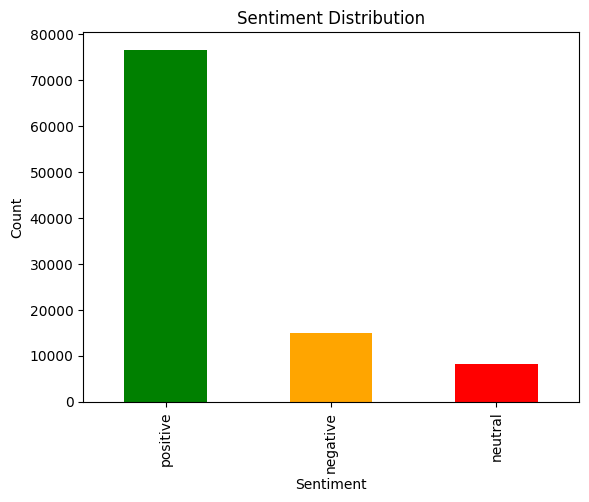

In [17]:
def visualize_sentiments(df):
    sentiment_counts = df['sentiment'].value_counts()
    sentiment_counts.plot(kind='bar', color=['green', 'orange', 'red'])
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

visualize_sentiments(df)

# Part 1. Sentiment Analysis
We'll use the nltk library's sentiment analysis tool for this task.

In [19]:
# Download the stopwords, 'portuguese'

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stop_wor = set(stopwords.words('portuguese'))
# Convert the set to a list
stop_words_list = list(stop_wor)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataliamarko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Vectorize text

In [21]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [22]:
vectorizer = TfidfVectorizer(stop_words=stop_words_list)
X = vectorizer.fit_transform(df['merged_review'])
y = df['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train several model to see wich one better fits our data

In [24]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': MultinomialNB()
}

# Initialize results list
results = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

### Display results

In [26]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.85025,0.808082,0.85025,0.813502
1,SVM,0.85570,0.825713,0.85570,0.817691
2,Random Forest,0.85065,0.802500,0.85065,0.813283
3,Gradient Boosting,0.82600,0.780710,0.82600,0.780113
4,Naive Bayes,0.83465,0.792539,0.83465,0.788933


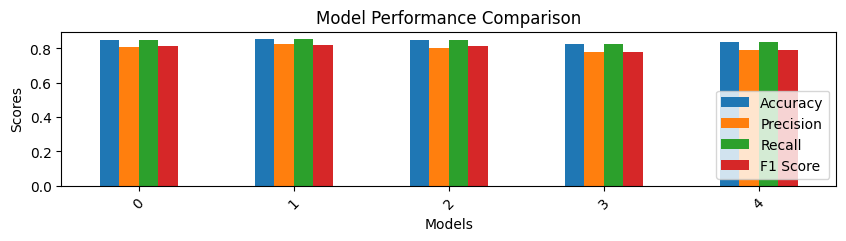

In [27]:
results_df.plot(kind='bar', figsize=(10, 2))
plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

### Choose the best

So, the Support Vector Machine (SVM) appears to be the best choice. 
-  the highest accuracy of 0.8557.
- the highest precision of 0.8257, indicating it performs well in predicting the positive class.
- F1 score is among the highest at 0.818, suggesting a good balance between precision and recall.

### Final train of the best model on all data

In [31]:
svm_model = SVC(kernel='linear')
svm_model.fit(X, y)
y_pred = svm_model.predict(X)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

In [32]:
# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8695
Precision: 0.8652
Recall: 0.8695
F1 Score: 0.8392


In [37]:
# Get unique classes
unique_classes = np.unique(y)
print(f"Unique Classes: {unique_classes}")

Unique Classes: ['negative' 'neutral' 'positive']


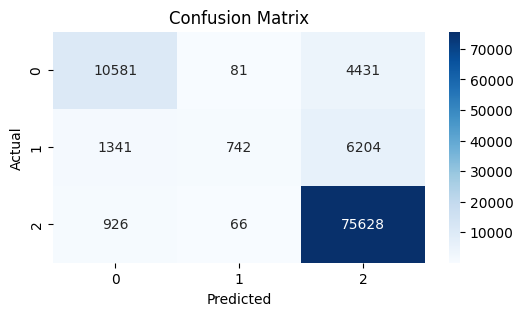

In [39]:
conf_matrix = confusion_matrix(y, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# cross-validation

#from sklearn.model_selection import cross_val_score
#cv_scores_f1 = cross_val_score(svm_model, X, y, cv=3, scoring='f1_weighted')

# Print cross-validation results
#print(f"Cross-Validation F1 Score: {np.mean(cv_scores_f1):.4f} ± {np.std(cv_scores_f1):.4f}")

Interpreting:
- The model performs very well on class 2, with the highest number of true positives (76,474) and relatively low false negatives (135) and false positives (11).
- Class 0 also shows good performance with 11,266 true positives, but it has a notable number of false negatives (3,812), indicating that many instances of class 0 are being misclassified as class 2.
- Class 1 has the lowest performance, with 2,842 true positives and a significant number of false negatives (5,216), indicating that many instances of class 1 are also being misclassified as class 2.

### save the model

In [43]:
import joblib
joblib.dump(svm_model, 'svm_model.joblib')
print("Model saved to 'svm_model.joblib'")

Model saved to 'svm_model.joblib'


### load the model for future predictions

In [45]:
loaded_model = joblib.load('svm_model.joblib')
y_pred = loaded_model.predict(X)

## Part 2: Price Extraction

In [46]:
df.head()

,review_id,review_score,sentiment,merged_review
0,7bc2406110b926393aa56f80a40eba40,4,positive,
1,80e641a11e56f04c1ad469d5645fdfde,5,positive,
2,228ce5500dc1d8e020d8d1322874b6f0,5,positive,
3,e64fb393e7b32834bb789ff8bb30750e,5,positive,recebi bem antes do prazo estipulado
4,f7c4243c7fe1938f181bec41a392bdeb,5,positive,parabns lojas lannister adorei comprar pela i...


In [52]:
def extract_prices(comment):
    patterns = [
        r'\b\d+[\.,]?\d*\s*reais\b',
        r'\b\d+[\.,]?\d*\s*BRL\b',
        r'\b\d+[\.,]?\d*\s*\$\b',
        r'\b\d+[\.,]?\d*\s*dólar(?:es)?\b'
    ]
    prices = []
     
    for pattern in patterns:
        matches = re.findall(pattern, comment)
        if matches:
            numeric_part = re.findall(r'\d+[\.,]?\d*', matches[0])[0]
            numeric_value = float(numeric_part.replace(',', '.'))
            return numeric_value
    return prices

df['extracted_prices'] = df['merged_review'].apply(extract_prices)
df.head(2)

,review_id,review_score,sentiment,merged_review,extracted_prices
0,7bc2406110b926393aa56f80a40eba40,4,positive,,[]
1,80e641a11e56f04c1ad469d5645fdfde,5,positive,,[]


### The correlation between negative sentiment and price mention in the commments

In [55]:
df['extracted_prices'] = pd.to_numeric(df['extracted_prices'], errors='coerce') 
df[df['extracted_prices'] > 5]

,review_id,review_score,sentiment,merged_review,extracted_prices
334,b396ba75350276a6cc1993b6627dceea,1,negative,lamenetvel boa noite lamentvel esta loja que t...,5000.0
1489,b703764760e6e5d534a8940a12fca101,1,negative,s veio uma capa comprei 3 a paguei mais de 10...,100.0
2166,9af54c3ce6be8d6c49c45fd02e06f1cf,1,negative,o produto no foi entregue na minha casa tive ...,20.0
3349,591b2149765d02a35621930a4800ceb9,1,negative,nem a nota foi emitida cansei e solicitei ao ...,100.0
6040,dcb5a99ac081043da014276823f67c51,1,negative,no anncio dizia marca canon e eu recebi um pr...,10.0
8334,c9f345723b16bba74d67ccba383f08b2,1,negative,produto no corresponde ao da foto pois o que ...,15.0
17923,7afb827cafa3ccc34132851ee76415e3,1,negative,relgio horrvel pssimo sem qualidade material ...,10.0
18571,7433f58b9a195ac20e00e108ac6e4de5,1,negative,nao indicaria pq o produto chegou em 1 dia e ...,12.0
20120,4f058f79427c719b0b603b7cad80c48d,1,negative,produto falsificado produto barato vendido no ...,20.0
22058,c8aa80ce5db16def531c812c22e86373,1,negative,uma merda bem comprei um produto que custava...,26100.0


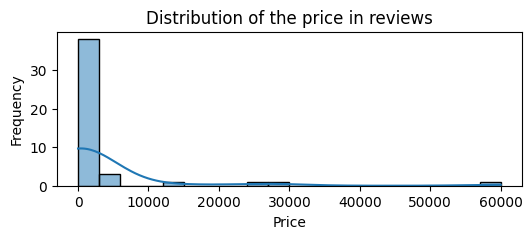

In [57]:
plt.figure(figsize=(6, 2))
sns.histplot(df['extracted_prices'], bins=20, kde=True)
plt.title('Distribution of the price in reviews')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### create the function

In [60]:
def extract_prices_from_comment(df, columns):
    df_pp = df[columns].copy()

    def map_sentiment(review_score):
        if review_score >= 4:
            return 'positive'
        elif review_score == 3:
            return 'neutral'
        else:
            return 'negative'

    df_pp['sentiment'] = df['review_score'].apply(map_sentiment)

    def preprocess_text(text):
        text = text.fillna('')
        text = text.astype(str).str.lower()
        text = text.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
        text = text.str.replace('\s+', ' ', regex=True)
        return text

    df_pp['review_comment_title'] = preprocess_text(df_pp['review_comment_title'])
    df_pp['review_comment_message'] = preprocess_text(df_pp['review_comment_message'])
    df_pp['merged_review'] = df_pp['review_comment_title'] + ' ' + df_pp['review_comment_message']
    df_pp.drop(['review_comment_title', 'review_comment_message'], axis=1, inplace=True)

    def extract_prices(comment):
        patterns = [
            r'\b\d+[\.,]?\d*\s*reais\b',
            r'\b\d+[\.,]?\d*\s*BRL\b',
            r'\b\d+[\.,]?\d*\s*\$\b',
            r'\b\d+[\.,]?\d*\s*dólar(?:es)?\b'
        ]
        prices = []

        for pattern in patterns:
            matches = re.findall(pattern, comment)
            if matches:
                numeric_part = re.findall(r'\d+[\.,]?\d*', matches[0])[0]
                numeric_value = float(numeric_part.replace(',', '.'))
                return numeric_value
        return None
    df_pp['extracted_prices'] = df_pp['merged_review'].apply(extract_prices)
    df_pp['extracted_prices'] = pd.to_numeric(df_pp['extracted_prices'], errors='coerce')

    return df_pp

### Let's try it

In [62]:
order_reviews_df = pd.read_csv(path + 'order_reviews.csv')
order_reviews_df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [64]:
columns = ['review_id', 'review_score', 'review_comment_title','review_comment_message']

extracted_prices_df = extract_prices_from_comment(order_reviews_df, columns)
extracted_prices_df

,review_id,review_score,sentiment,merged_review,extracted_prices
0,7bc2406110b926393aa56f80a40eba40,4,positive,,NaN
1,80e641a11e56f04c1ad469d5645fdfde,5,positive,,NaN
2,228ce5500dc1d8e020d8d1322874b6f0,5,positive,,NaN
3,e64fb393e7b32834bb789ff8bb30750e,5,positive,recebi bem antes do prazo estipulado,NaN
4,f7c4243c7fe1938f181bec41a392bdeb,5,positive,parabns lojas lannister adorei comprar pela i...,NaN
...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,5,positive,,NaN
99996,b3de70c89b1510c4cd3d0649fd302472,5,positive,excelente mochila entrega super rpida super r...,NaN
99997,1adeb9d84d72fe4e337617733eb85149,4,positive,,NaN
99998,be360f18f5df1e0541061c87021e6d93,1,negative,solicitei a compra de uma capa de retrovisor ...,NaN


In [66]:
extracted_prices_df[extracted_prices_df['extracted_prices'] > 0]

,review_id,review_score,sentiment,merged_review,extracted_prices
334,b396ba75350276a6cc1993b6627dceea,1,negative,lamenetvel boa noite lamentvel esta loja que t...,5000.0
1489,b703764760e6e5d534a8940a12fca101,1,negative,s veio uma capa comprei 3 a paguei mais de 10...,100.0
2166,9af54c3ce6be8d6c49c45fd02e06f1cf,1,negative,o produto no foi entregue na minha casa tive ...,20.0
3349,591b2149765d02a35621930a4800ceb9,1,negative,nem a nota foi emitida cansei e solicitei ao ...,100.0
6040,dcb5a99ac081043da014276823f67c51,1,negative,no anncio dizia marca canon e eu recebi um pr...,10.0
8334,c9f345723b16bba74d67ccba383f08b2,1,negative,produto no corresponde ao da foto pois o que ...,15.0
11958,10460eaad2a97e45e5735e7058d778b3,3,neutral,produto com aparncia de usado tinta da logo g...,5.0
17923,7afb827cafa3ccc34132851ee76415e3,1,negative,relgio horrvel pssimo sem qualidade material ...,10.0
17968,5e7642f0df935314a6aae748e824788a,2,negative,o produto possui pssima qualidade igual um ta...,5.0
18571,7433f58b9a195ac20e00e108ac6e4de5,1,negative,nao indicaria pq o produto chegou em 1 dia e ...,12.0


### bonus 

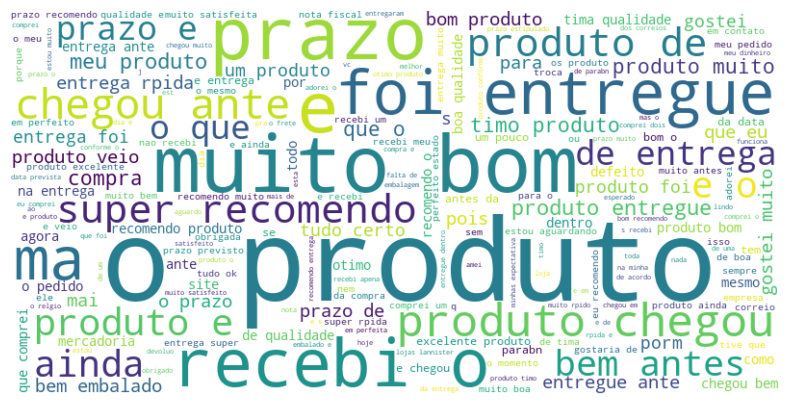

In [69]:
from wordcloud import WordCloud

text = ' '.join(extracted_prices_df['merged_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png')
plt.show()

The word cloud reveals that customer reviews primarily focus on the product itself (especially its quality) and delivery (timeliness and experience). Overall sentiment is positive, with mentions of "good," "excellent," and "recommend." However, some negative feedback exists regarding problems and delays. This suggests that the company should maintain its strengths in product quality and timely delivery, while investigating and addressing the causes of negative experiences.